# TICL Pattern Recognition

This notebook builds a labeled dataset for identifying complete and incomplete tracksters.

In [22]:
import uproot
from utils.plotting_utils import plot_event
from utils.matching_utils import split_on_shared_energy, get_eid_splits, unfold_tracksters, get_highest_energy_fraction_simtracksters
%matplotlib inline

# double gamma (two photons)
file_name = "~/data/multiparticle/new_ntuples_14132277_900.root"

tracksters_ds    = {file_name: "ticlNtuplizer/tracksters"}
simtracksters_ds = {file_name: "ticlNtuplizer/simtrackstersSC"}
associations_ds  = {file_name: "ticlNtuplizer/associations"}

Load the datasets

In [23]:
tracksters = uproot.open(tracksters_ds)
simtracksters = uproot.open(simtracksters_ds)
associations = uproot.open(associations_ds)

Print the available attributes

In [24]:
tracksters.show(name_width=40)

name                                     | typename                 | interpretation                
-----------------------------------------+--------------------------+-------------------------------
event                                    | uint32_t                 | AsDtype('>u4')
NClusters                                | uint32_t                 | AsDtype('>u4')
NTracksters                              | uint32_t                 | AsDtype('>u4')
time                                     | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
timeError                                | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
regressed_energy                         | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
raw_energy                               | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
raw_em_energy                            | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
raw_pt                                

In [25]:
simtracksters.show(name_width=40)

name                                     | typename                 | interpretation                
-----------------------------------------+--------------------------+-------------------------------
stsSC_event                              | uint32_t                 | AsDtype('>u4')
stsSC_NTracksters                        | uint32_t                 | AsDtype('>u4')
stsSC_time                               | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
stsSC_timeError                          | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
stsSC_regressed_energy                   | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
stsSC_raw_energy                         | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
stsSC_raw_em_energy                      | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
stsSC_raw_pt                             | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
stsSC_raw_em_pt       

In [26]:
associations.show(name_width=40)

name                                     | typename                 | interpretation                
-----------------------------------------+--------------------------+-------------------------------
tsCLUE3D_recoToSim_SC                    | std::vector<std::vect... | AsObjects(AsVector(True, As...
tsCLUE3D_recoToSim_SC_score              | std::vector<std::vect... | AsObjects(AsVector(True, As...
tsCLUE3D_simToReco_SC                    | std::vector<std::vect... | AsObjects(AsVector(True, As...
tsCLUE3D_simToReco_SC_score              | std::vector<std::vect... | AsObjects(AsVector(True, As...
tsCLUE3D_simToReco_SC_sharedE            | std::vector<std::vect... | AsObjects(AsVector(True, As...
tsCLUE3D_recoToSim_CP                    | std::vector<std::vect... | AsObjects(AsVector(True, As...
tsCLUE3D_recoToSim_CP_score              | std::vector<std::vect... | AsObjects(AsVector(True, As...
tsCLUE3D_simToReco_CP                    | std::vector<std::vect... | AsObjects(AsVector(Tr

In [27]:
# print some stats
print("Events:", tracksters["event"].array())
print("Rec Tracksters:", tracksters["NTracksters"].array())
print("Sim Tracksters:", simtracksters["stsSC_NTracksters"].array())

Events: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Rec Tracksters: [178, 167, 190, 178, 188, 178, 205, 197, ... 206, 174, 205, 196, 231, 188, 172, 194]
Sim Tracksters: [45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45]


SimTracksters: 45
RecoTracksters: 167


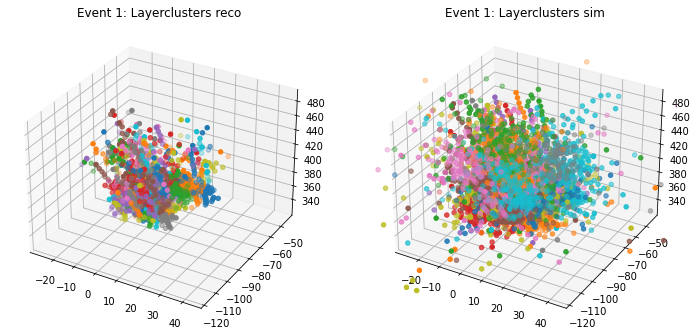

In [28]:
eid = 1
plot_event(tracksters, simtracksters, eid, legend=False)
print("SimTracksters:", simtracksters["stsSC_NTracksters"].array()[eid])
print("RecoTracksters:", tracksters["NTracksters"].array()[eid])

### Association scores
- 1 means completely unmatched
- 0 means a perfect 

The idea is to use argmax over the scores and then get the index of the best matched trackster

In [29]:
r2si = associations["tsCLUE3D_recoToSim_SC"].array()[eid]
r2s = associations["tsCLUE3D_recoToSim_SC_score"].array()[eid] # [tracksters] -> [simtracksters]

s2ri = associations["tsCLUE3D_simToReco_SC"].array()[eid]
s2r = associations["tsCLUE3D_simToReco_SC_score"].array()[eid] # [simtracksters] -> [tracksters]

print("Reco to sim:", r2s)
print("Reco to sim indexes:", r2si)

print("Sim to reco:", s2r)
print("Sim to reco indexes:", s2ri)

Reco to sim: [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]]
Reco to sim indexes: [[31, 21, 0, 24, 25, 26, 27, 28, 29, 30, ... 13, 14, 15, 16, 17, 18, 19, 20, 21, 5]]
Sim to reco: [[0.568, 0.961, 0.979, 1, 1, 1, 1, 1, 1, 1, 1, ... 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]
Sim to reco indexes: [[165, 104, 85, 1, 59, 130, 17, 113, 105, ... 69, 98, 72, 73, 74, 75, 76, 77, 79]]


### Training set categories:
- **perfect match**
    - same number of sim and reco tracksters
    - only one matched trackster below a threshold
- **mix-up** (skip for now)
    - same number of sim and reco tracksters
    - multiple matched tracksters below a threshold
    - should be split and reclustered?
- **overmerged** (skip for now)
    - more sim tracksters than reco tracksters
    - should be split
- **split**
    - more reco tracksters than sim tracksters
    - multiple well matched tracksters
    - should be joined

In [30]:
perfect_eids, split_eids = get_eid_splits(tracksters, simtracksters, associations)

Perfect events: []
Split events: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


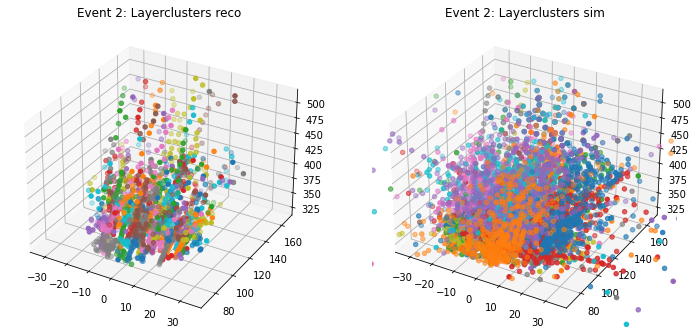

In [32]:
print("Perfect events:", perfect_eids)
print("Split events:", split_eids)

if perfect_eids:
    plot_event(tracksters, simtracksters, perfect_eids[0], legend=False)

plot_event(tracksters, simtracksters, split_eids[2], legend=False)

### Incomplete trackster identification

Not all tracksters in a split event are incomplete.
- Try to identify the most mismatched tracksters
- We even know how many they should be

Incomplete trackster candidates
- use fractions simToReco shared energy (fraction shared to total)
- tracksters with the smallest fraction are probably the ones we need to merge in
- TODO: get histograms of these fractions (to test the separation)

Total reco tracksters: 3733, complete: 318, Incomplete: 2833


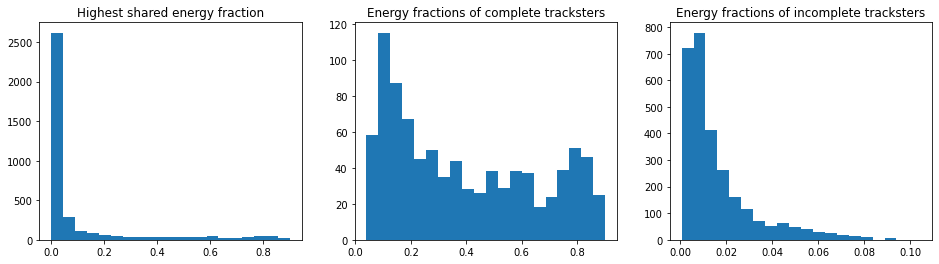

In [33]:
h_frac = {eid:get_highest_energy_fraction_simtracksters(tracksters, simtracksters, associations, eid) for eid in split_eids}

complete_tracksters, incomplete_tracksters = split_on_shared_energy(
    tracksters,
    simtracksters,
    h_frac,
    split_eids,
    histogram=True
)

### Inspect the results

Event 0: complete: [76, 42, 10, 7, 15, 73, 11, 8, 9, 175, 14, 13, 16] incomplete : [99, 85, 35, 141, 169, 79, 56, 33, 102, 29, 32, 95, 20, 104, 24, 46, 52, 67, 28, 39, 173, 83, 36, 139, 111, 134, 122, 158, 176, 49, 91, 25, 160, 171, 31, 38, 109, 86, 115, 138, 3, 87, 123, 150, 68, 89, 144, 43, 92, 133, 72, 41, 26, 74, 149, 60, 69, 84, 129, 77, 125, 121, 93, 48, 27, 70, 128, 151, 113, 156, 117, 142, 101, 152, 146, 54, 34, 140, 166, 18, 137, 126, 63, 119, 23, 78, 40, 22, 110, 82, 165, 120, 132, 135, 47, 157, 112, 59, 65, 108, 75, 159, 81, 96, 94, 107, 30, 55, 143, 51, 45, 124, 127, 131, 88, 136, 116, 21, 98, 0, 170, 62, 167, 177, 153, 147, 103, 100, 148, 71, 50, 44, 155]
Event 1: complete: [97, 164, 32, 60, 120, 125, 20, 2, 25, 6, 5, 1, 17, 11, 3, 14, 21, 10, 12, 7, 13, 18] incomplete : [38, 26, 66, 33, 69, 23, 158, 57, 131, 76, 22, 63, 49, 137, 105, 44, 61, 114, 91, 161, 24, 41, 8, 78, 95, 37, 110, 29, 157, 73, 115, 93, 135, 90, 129, 145, 134, 50, 124, 141, 40, 15, 28, 27, 39, 149, 75, 1

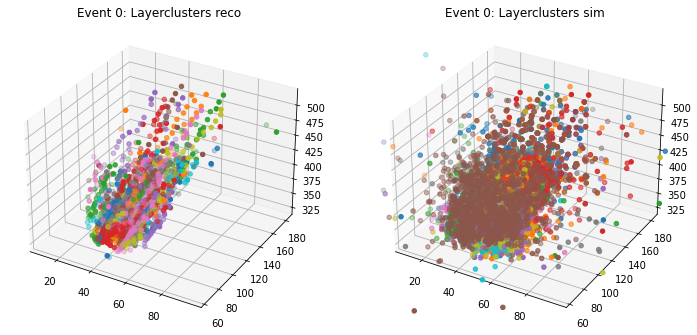

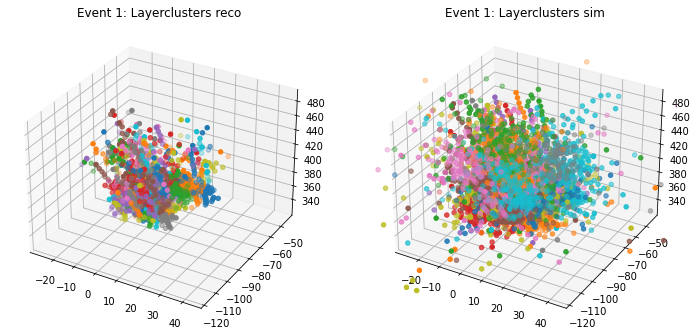

In [34]:
for i, (eid, it) in enumerate(incomplete_tracksters[:2]):
    print(f"Event {eid}: complete: {complete_tracksters[i][1]} incomplete : {it}")
    plot_event(tracksters, simtracksters, eid, legend=False)

In [ ]:
vertices_x = []
vertices_y = []
vertices_z = []
vertices_energy = []
vertices_indexes = []
trackster_label = []
trackster_event = []

datafiles = [
    f"new_ntuples_14132277_{x}.root" for x in range(900, 950)
]

datadir = "~/data/multiparticle"

for datafile in datafiles:
    print("Processing file:", datafile)
    filepath = f"{datadir}/{datafile}"
    try:
        tracksters = uproot.open({filepath: "ticlNtuplizer/tracksters"})
        simtracksters = uproot.open({filepath: "ticlNtuplizer/simtrackstersSC"})
        associations = uproot.open({filepath: "ticlNtuplizer/associations"})
    except:
        print("file not found:", datafile)
        continue

    # categorize events into perfect and split
    perfect_eids, split_eids = get_eid_splits(tracksters, simtracksters, associations)

    # get the perfect tracksters
    perfect_tracksters = unfold_tracksters(tracksters, perfect_eids)

    # get highest energy simtracksters for each split eids
    h_frac = {
        eid:get_highest_energy_fraction_simtracksters(tracksters, simtracksters, associations, eid)
        for eid in split_eids
    }

    # get the complete and incomplete tracksters from split events
    complete_tracksters, incomplete_tracksters = split_on_shared_energy(
        tracksters,
        simtracksters,
        h_frac,
        split_eids
    )

    # assign labels to trackster sets
    set_labels = (
        (incomplete_tracksters, 0),
        (complete_tracksters, 1),
        (perfect_tracksters, 1),
    )

    vx = tracksters["vertices_x"].array()
    vy = tracksters["vertices_y"].array()
    vz = tracksters["vertices_z"].array()
    ve = tracksters["vertices_energy"].array()
    vi = tracksters["vertices_indexes"].array()

    for tset, label in set_labels:
        for eid, tids in tset:
            for tid in tids:
                vertices_x.append(vx[eid][tid])
                vertices_y.append(vy[eid][tid])
                vertices_z.append(vz[eid][tid])
                vertices_energy.append(ve[eid][tid])
                vertices_indexes.append(vi[eid][tid])
                trackster_label.append(label)
                trackster_event.append(eid)

In [21]:
ds = uproot.recreate("data/trackster_tags_1ke_multi.root")
ds["tracksters"] = {
    "vertices_x": vertices_x,
    "vertices_y": vertices_y,
    "vertices_z": vertices_z,
    "vertices_energy": vertices_energy,
    "vertices_indexes": vertices_indexes,
    "trackster_label": trackster_label,
    "trackster_event": trackster_event,
}
ds.close()